In [2]:
import pandas as pd
import re
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D, GRU
from sklearn.model_selection import train_test_split
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
from keras_tuner import RandomSearch
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


c:\Users\Radosz\Desktop\sem7\Sentiment_analysys\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# za 1 razem pobrac
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt_tab')

In [4]:
df = pd.read_csv('training.csv', header=None, names=['sentiment', 'id', 'date', 'query', 'user', 'text'], encoding='ISO-8859-1')
df = df.drop(columns=['query', 'id', 'user', 'date'])

C:\Users\Radosz\AppData\Local\Temp\ipykernel_14536\1493389583.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


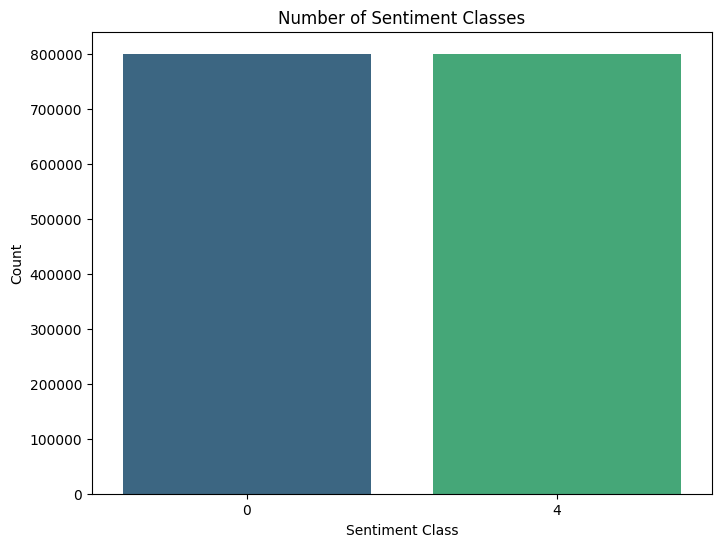

In [5]:
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title("Number of Sentiment Classes")
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.show()

In [6]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [7]:
def count_hashtags(text):
    return len(re.findall(r'#', text))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove numbers (optional: uncomment if needed)
    # text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['hashtag_count'] = df['text'].apply(count_hashtags)

In [8]:
df['cleaned_text'] = df['text'].apply(clean_text)
df

,sentiment,text,hashtag_count,cleaned_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,awww thats bummer shoulda got david carr third...
1,0,is upset that he can't update his Facebook by ...,0,upset cant update facebook texting might cry r...
2,0,@Kenichan I dived many times for the ball. Man...,0,dived many time ball managed save 50 rest go b...
3,0,my whole body feels itchy and like its on fire,0,whole body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",0,behaving im mad cant see
...,...,...,...,...
1599995,4,Just woke up. Having no school is the best fee...,0,woke school best feeling ever
1599996,4,TheWDB.com - Very cool to hear old Walt interv...,0,thewdbcom cool hear old walt interview â
1599997,4,Are you ready for your MoJo Makeover? Ask me f...,0,ready mojo makeover ask detail
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...,0,happy 38th birthday boo alll time tupac amaru ...


In [9]:
# Tokenizacja
num_words=10000
max_length = 20

tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

X_padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

y_binary = [1 if label == 4 else 0 for label in df['sentiment']]

In [10]:
# Podział na dane treningowe, walidacyjne i testowe
X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y_binary, test_size=0.3, stratify=y_binary, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
y_train = np.array(y_train, dtype=np.int32)
y_val = np.array(y_val, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)

In [11]:
# Zbiory do wybory hiperparametrów
X_train_subset = X_train[::10]
y_train_subset = y_train[::10]
X_val_subset = X_val[::10]
y_val_subset = y_val[::10]

In [12]:
X_train_subset.shape

(112000, 20)

In [13]:
from tensorflow.keras import backend as K
# F1 score
def f1_m(y_true, y_pred):
    y_true = K.cast(y_true, K.floatx())  # Ensure y_true is cast to float

    epsilon = K.epsilon()
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + epsilon))

# Precision (precyzja)
def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, K.floatx())  # Ensure y_true is cast to float

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Recall (czułość)
def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, K.floatx())  # Ensure y_true is cast to float

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

Reloading Tuner from random_search_lstm_tuning\lstm_tuning_with_lr\tuner0.json
Najlepsze hiperparametry:
Liczba jednostek LSTM: 96
Współczynnik dropout: 0.4
Liczba jednostek Dense: 96
Współczynnik uczenia: 0.0011807478699245395
Rozmiar batcha: 16


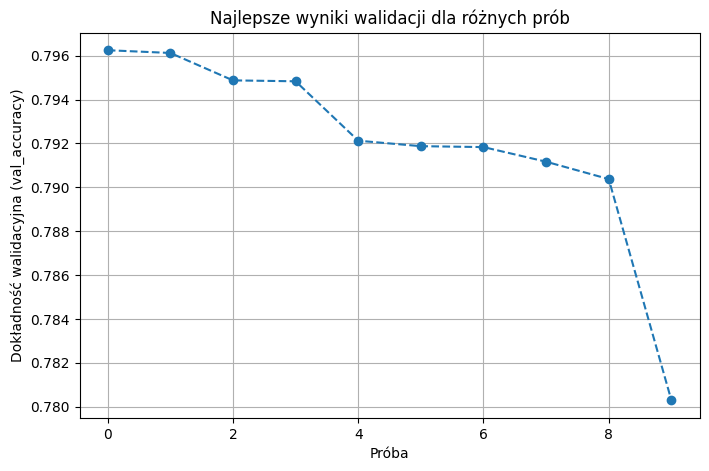

In [14]:

def build_model(hp):
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = Adam(learning_rate=learning_rate)
    
    model = Sequential([
        Embedding(
            input_dim=num_words, 
            output_dim=hp.Choice('embedding_dim', [64, 128, 256])
        ),
        LSTM(
            units=hp.Int('lstm_units', min_value=32, max_value=128, step=32), 
            return_sequences=False
        ),
        Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)),
        Dense(
            units=hp.Int('dense_units', min_value=16, max_value=128, step=16), 
            activation='relu'
        ),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', f1_m, precision_m, recall_m]
    )
    return model

# Random Search
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='random_search_lstm_tuning',
    project_name='lstm_tuning_with_lr'
)

# Zatrzymanie uczenia przy braku poprawy
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3,          
    restore_best_weights=True  
)

# Wykonywanie wyszukiwania z EarlyStopping
tuner.search(
    X_train_subset, y_train_subset,
    validation_data=(X_val_subset, y_val_subset),
    epochs=10,
    batch_size=tuner.oracle.hyperparameters.Choice('batch_size', [16, 32, 64]),
    callbacks=[early_stopping]
)

# Pobranie najlepszych hiperparametrów
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Najlepsze hiperparametry:")
print(f"Liczba jednostek LSTM: {best_hps.get('lstm_units')}")
print(f"Współczynnik dropout: {best_hps.get('dropout_rate')}")
print(f"Liczba jednostek Dense: {best_hps.get('dense_units')}")
print(f"Współczynnik uczenia: {best_hps.get('learning_rate')}")
print(f"Rozmiar batcha: {best_hps.get('batch_size')}")

# 5. Wizualizacja wyników
# Pobranie najlepszych prób
best_trials = tuner.oracle.get_best_trials(num_trials=10)
# Zbieranie wyników walidacyjnych tylko dla prób, które mają 'val_accuracy'
val_accuracies = [
    trial.metrics.metrics['val_accuracy'].get_history()[-1].value
    for trial in best_trials
    if 'val_accuracy' in trial.metrics.metrics and trial.metrics.metrics['val_accuracy'].get_history()
]

# Rysowanie wykresu tylko, jeśli mamy jakieś wyniki
if val_accuracies:
    plt.figure(figsize=(8, 5))
    plt.plot(val_accuracies, marker='o', linestyle='--')
    plt.title('Najlepsze wyniki walidacji dla różnych prób')
    plt.xlabel('Próba')
    plt.ylabel('Dokładność walidacyjna (val_accuracy)')
    plt.grid(True)
    plt.show()
else:
    print("Brak wyników walidacyjnych do wizualizacji.")

Reloading Tuner from random_search_cnn_tuning\cnn_tuning\tuner0.json
Najlepsze hiperparametry:
Liczba filtrów w Conv1D: 96
Rozmiar jądra (kernel_size): 3
Liczba jednostek Dense: 96
Współczynnik dropout: 0.30000000000000004
Współczynnik uczenia: 0.00011698793363003295
Rozmiar batcha: 64


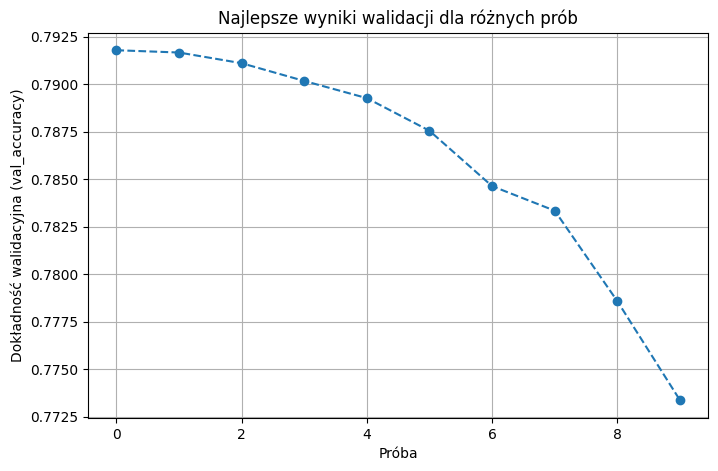

In [15]:
def build_model(hp):
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = Adam(learning_rate=learning_rate)
    
    model = Sequential([
        Embedding(
            input_dim=num_words, 
            output_dim=hp.Choice('embedding_dim', [64, 128, 256])
        ),
        Conv1D(
            filters=hp.Int('conv_filters', min_value=32, max_value=128, step=32), 
            kernel_size=hp.Choice('kernel_size', [3, 5, 7]), 
            activation='relu'
        ),
        GlobalMaxPooling1D(),
        Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(
            units=hp.Int('dense_units', min_value=16, max_value=128, step=16), 
            activation='relu'
        ),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', f1_m, precision_m, recall_m]
    )
    return model

# Random Search
tuner_cnn = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Liczba prób Random Search
    executions_per_trial=1,
    directory='random_search_cnn_tuning',
    project_name='cnn_tuning'
)

# EarlyStopping: zatrzymanie po braku poprawy

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3,  
    restore_best_weights=True  
)

# Wyszukiwanie hiperparametrów
tuner_cnn.search(
    X_train_subset, y_train_subset,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=tuner_cnn.oracle.hyperparameters.Choice('batch_size', [16, 32, 64]),
    callbacks=[early_stopping]
)

# Najlepsze hiperparametry
best_hps_cnn = tuner_cnn.get_best_hyperparameters(num_trials=1)[0]
print(f"Najlepsze hiperparametry:")
print(f"Liczba filtrów w Conv1D: {best_hps_cnn.get('conv_filters')}")
print(f"Rozmiar jądra (kernel_size): {best_hps_cnn.get('kernel_size')}")
print(f"Liczba jednostek Dense: {best_hps_cnn.get('dense_units')}")
print(f"Współczynnik dropout: {best_hps_cnn.get('dropout_rate')}")
print(f"Współczynnik uczenia: {best_hps_cnn.get('learning_rate')}")
print(f"Rozmiar batcha: {best_hps_cnn.get('batch_size')}")

best_trials_cnn = tuner_cnn.oracle.get_best_trials(num_trials=10)
# Zbieranie wyników walidacyjnych tylko dla prób, które mają 'val_accuracy'
val_accuracies_cnn = [
    trial.metrics.metrics['val_accuracy'].get_history()[-1].value
    for trial in best_trials_cnn
    if 'val_accuracy' in trial.metrics.metrics and trial.metrics.metrics['val_accuracy'].get_history()
]

# Rysowanie wykresu tylko, jeśli mamy jakieś wyniki
if val_accuracies_cnn:
    plt.figure(figsize=(8, 5))
    plt.plot(val_accuracies_cnn, marker='o', linestyle='--')
    plt.title('Najlepsze wyniki walidacji dla różnych prób')
    plt.xlabel('Próba')
    plt.ylabel('Dokładność walidacyjna (val_accuracy)')
    plt.grid(True)
    plt.show()
else:
    print("Brak wyników walidacyjnych do wizualizacji.")

Trial 10 Complete [00h 03m 34s]
val_accuracy: 0.7943750023841858

Best val_accuracy So Far: 0.7964166402816772
Total elapsed time: 00h 46m 38s
Najlepsze hiperparametry:
Liczba jednostek GRU: 32
Współczynnik dropout: 0.2
Liczba jednostek Dense: 128
Współczynnik uczenia: 0.001078858555498738
Rozmiar batcha: 16


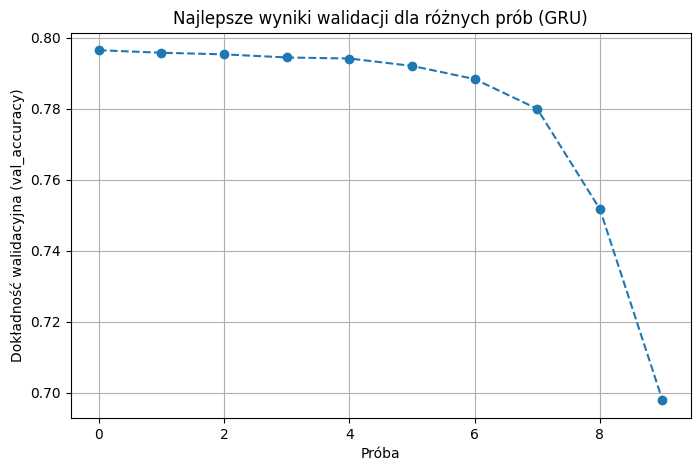

In [16]:
def build_gru_model(hp):
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = Adam(learning_rate=learning_rate)
    
    model = Sequential([
        Embedding(
            input_dim=num_words, 
            output_dim=hp.Choice('embedding_dim', [64, 128, 256])
        ),
        GRU(
            units=hp.Int('gru_units', min_value=32, max_value=128, step=32), 
            return_sequences=False
        ),
        Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)),
        Dense(
            units=hp.Int('dense_units', min_value=16, max_value=128, step=16), 
            activation='relu'
        ),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', f1_m, precision_m, recall_m]
    )
    return model

# Random Search
tuner_gru = RandomSearch(
    build_gru_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='random_search_gru_tuning',
    project_name='gru_tuning_with_lr'
)

# Zatrzymanie uczenia przy braku poprawy
early_stopping_gru = EarlyStopping(
    monitor='val_loss', 
    patience=3,          
    restore_best_weights=True  
)

# Wykonywanie wyszukiwania z EarlyStopping
tuner_gru.search(
    X_train_subset, y_train_subset,
    validation_data=(X_val_subset, y_val_subset),
    epochs=10,
    batch_size=tuner_gru.oracle.hyperparameters.Choice('batch_size', [16, 32, 64]),
    callbacks=[early_stopping_gru]
)

# Pobranie najlepszych hiperparametrów
best_hps_gru = tuner_gru.get_best_hyperparameters(num_trials=1)[0]
print(f"Najlepsze hiperparametry:")
print(f"Liczba jednostek GRU: {best_hps_gru.get('gru_units')}")
print(f"Współczynnik dropout: {best_hps_gru.get('dropout_rate')}")
print(f"Liczba jednostek Dense: {best_hps_gru.get('dense_units')}")
print(f"Współczynnik uczenia: {best_hps_gru.get('learning_rate')}")
print(f"Rozmiar batcha: {best_hps_gru.get('batch_size')}")

# Wizualizacja wyników
best_trials_gru = tuner_gru.oracle.get_best_trials(num_trials=10)
val_accuracies_gru = [
    trial.metrics.metrics['val_accuracy'].get_history()[-1].value
    for trial in best_trials_gru
    if 'val_accuracy' in trial.metrics.metrics and trial.metrics.metrics['val_accuracy'].get_history()
]

if val_accuracies_gru:
    plt.figure(figsize=(8, 5))
    plt.plot(val_accuracies_gru, marker='o', linestyle='--')
    plt.title('Najlepsze wyniki walidacji dla różnych prób (GRU)')
    plt.xlabel('Próba')
    plt.ylabel('Dokładność walidacyjna (val_accuracy)')
    plt.grid(True)
    plt.show()
else:
    print("Brak wyników walidacyjnych do wizualizacji.")
